# Tarea 5
Guido Salazar

## Algoritmos

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from random import uniform
from scipy.integrate import solve_ivp, odeint


In [ ]:
def eigen_values_symbolic(A:sp.Matrix, param, var, x0, eval=None):
  """
  Función que me devuelve los valores propios de la jacobiana del sistema de
  ecuaciones de dos variables de los modelos de presa y depredador.
  Entradas: A es el sistema de ecuaciones
            xo es la condición inicial (puntos de equilibrio del sistema)
  Salidas: eigenvalues son los valores propios de la jacobiana del sistema.
  """
  # Definir el símbolo lambda
  JA = A.jacobian(var)
  values = {}
  i = 0
  for v in var:
    values[v] = x0[i]
    i += 1

  JA = JA.subs(values)
  if eval != None: JA = JA.subs(eval)
  JA = sp.Matrix(JA)
  eigenvalues = JA.eigenvals()
  return eigenvalues

def diagrama_fases(f, var, params, n=30, title='Diagrama de Fases',
                  limx=(5,5), limy=(5,5), inicial=None, m=1000):
    # Crear una cuadrícula de puntos para el diagrama de fases
    x_vals = np.linspace(limx[0], limx[1], n)
    y_vals = np.linspace(limy[0], limy[1], n)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Sustituir los parámetros en la matriz
    A_evaluada = f.subs(params)

    # Convertir la matriz a una función NumPy
    f_lambdified = sp.lambdify(var, A_evaluada, 'numpy')

    # Calcular los vectores de campo
    DX, DY = f_lambdified(X, Y)

    # Graficar el diagrama de fases
    plt.figure(figsize=(10, 8))
    plt.quiver(X, Y, DX[0], DY[0], color='r', angles='xy')

    # Configurar el gráfico
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(limx[0], limx[1])
    plt.ylim(limy[0], limy[1])
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.grid()

    # Integrar las ecuaciones si se proporciona un valor inicial
    if inicial is not None:
        # Definir la función para la integración
        def modelo(t, vars):
            x, y = vars
            dxdt, dydt = f_lambdified(x, y)  # Evaluar el campo
            return [dxdt.item(), dydt.item()]  # Asegurarse de que sean escalares

        # Tiempo de integración
        t = np.linspace(0, m/10, m*10)  # Cambia el tiempo según sea necesario
        for x0 in inicial:
            # Resolver la ecuación diferencial
          sol = solve_ivp(modelo, (t[0], t[-1]), x0, t_eval=t)
          # Resolver el sistema de ecuaciones
          # Traza la solución en el diagrama de fases
          plt.plot(sol.y[0], sol.y[1], color='blue')

    plt.legend()
    plt.show()

def solve_system(A, var, solve, x0, index=0):
  """
  Función que me devuelve los ceros del sistema dado un valor inicial en una de
  las variables independientes.
  Entradas: A es el sistema de ecuaciones
            var es la variable independiente a reemplazarse por x0
            solve es la variable a resolver
            xo es la condición inicial
  Salidas: solution son las soluciones A(index).
  """

  # Sustituir el valor de x en la matriz
  A_substituida = A.subs(var, x0)

  # Resolver la ecuación A[0] = 0 para y
  # Esto solo considera la primera fila de la matriz
  soluciones = sp.solve(A_substituida[index], solve)
  return soluciones

## identificación de los modelos depredador presa

El artículo "Predator–Prey Models: A Review of Some Recent Advances" explora varios modelos de depredador-presa, centrándose en los avances recientes. Aquí hay un resumen de los modelos y modificaciones clave discutidos:


### Lotka–Volterra Model:

El modelo clásico de Lotka-Volterra sigue siendo la base para la mayoría de los modelos de depredador-presa. Describe las interacciones entre dos especies, presa y depredador, con términos lineales para la reproducción de la presa y la interacción depredador-presa. Se han hecho generalizaciones y extensiones para tener en cuenta comportamientos más complejos, como interacciones entre múltiples especies o retrasos en el tiempo.

$$
\begin{cases}
\dot{x} = x(a - by) \\
\dot{y} = y(-c + dx)
\end{cases}
$$

In [47]:
param = sp.symbols('a b c d')
x, y = sp.symbols('x y')

# Definir la matriz simbólica
A = sp.Matrix([x * (param[0] - param[1] * y),
                y * (-param[2] + param[3] * x)])


#### Estabilidad del Modelo

sea

$$
F(x,y)
\begin{cases}
\dot{x} = x(a - by) \\
\dot{y} = y(-c + dx)
\end{cases}
$$

Primer paso hallar los ceros:

$$
F(x^*) = 0 \\
\begin{cases}
0 = x(a - by) \\
0 = y(-c + dx)
\end{cases}
$$

Eq 1: $x^* = (0, 0)$

In [48]:
print(f"y = {solve_system(A, x, y, 0, index=1)}")

y = [0]


Eq 2: Si $x = \frac{c}{d}$, entonces \\
$
0 = \frac{c}{d}(a - by) ⇒ 0 = a - by ⇒ y = \frac{a}{b}
$
Por lo tanto, $x^* = \left(\frac{c}{d}, \frac{a}{b}\right)$

In [49]:
print(f"y={solve_system(A, x, y, param[2]/param[3])}")

y=[a/b]



Segundo paso Jacobiana:

$$
J(x) = \begin{pmatrix}
a - by & -bx \\
dy & -c+dx
\end{pmatrix}
$$

In [50]:
JB = A.jacobian([x, y])
sp.pprint(JB)

⎡a - b⋅y    -b⋅x  ⎤
⎢                 ⎥
⎣  d⋅y    -c + d⋅x⎦


Tercer paso hallar autovalores de todos los $x^*$ $det(J(x^*) - λI) = 0$

Con $x^* = (0, 0)$

$$
det(J(0,0) - λI) = det\left( \begin{pmatrix}
a-λ & 0 \\
0 & -c-λ
\end{pmatrix}\right)
$$

donde $ λ_1 = a ∧ λ_2 = -c$. Por casos:

1.   Si $a ∧ c ∈ R^+$ Como algunos valores propios tienen parte real negativa y otros positivos, entonces es una silla.
2.   Si $a ∈ R^+ ∧ c ∈ R^-$ Como todos los valores propios tienen parte real positivos, entonces es un nodo inestable.
3.   Si $a ∈ R^- ∧ c ∈ R^+$ Como todos los valores propios tienen parte real neagtiva, entonces es un nodo estable.
4.   Si $a ∧ c ∈ R^-$ Como algunos valores propios tienen parte real negativa y otros positivos, entonces es un punto silla.


In [51]:
print(eigen_values_symbolic(A, param, [x, y], [0, 0]))
print(eigen_values_symbolic(A, param, [x, y], [0, 0], eval={param[0]:1, param[2]:1}))
print(eigen_values_symbolic(A, param, [x, y], [0, 0], eval={param[0]:1, param[2]:-1}))
print(eigen_values_symbolic(A, param, [x, y], [0, 0], eval={param[0]:-1, param[2]:1}))
print(eigen_values_symbolic(A, param, [x, y], [0, 0], eval={param[0]:-1, param[2]:-1}))

{a: 1, -c: 1}
{1: 1, -1: 1}
{1: 2}
{-1: 2}
{-1: 1, 1: 1}



Con $x^* = \left(\frac{c}{d}, \frac{a}{b}\right)$

$$
det\left(J\left(\frac{c}{d}, \frac{a}{b}\right) - λI\right) = det\left(
\begin{pmatrix}
-λ & -\frac{bc}{d} \\
\frac{ad}{b} & -λ
\end{pmatrix}
\right)
$$

donde $ λ_1 = -\sqrt{-ac} ∧ λ_2 = \sqrt{-ac}$. Por casos:
1.   Si $a ∧ c ∈ R^+$ Como es puramente imaginario, entonces es un centro.
2.   Si $a ∈ R^+ ∧ c ∈ R^-$ Como algunos valores propios tienen parte real negativa y otros positivos, entonces es una silla
3.   Si $a ∈ R^- ∧ c ∈ R^+$ Como algunos valores propios tienen parte real negativa y otros positivos, entonces es una silla
4.   Si $a ∧ c ∈ R^-$ Como es puramente imaginario, entonces es un centro.

In [52]:
print(eigen_values_symbolic(A, param, [x, y], [param[2]/param[3], param[0]/param[1]]))
print(eigen_values_symbolic(A, param, [x, y], [param[2]/param[3], param[0]/param[1]], eval={param[0]:1, param[2]:1}))
print(eigen_values_symbolic(A, param, [x, y], [param[2]/param[3], param[0]/param[1]], eval={param[0]:1, param[2]:-1}))
print(eigen_values_symbolic(A, param, [x, y], [param[2]/param[3], param[0]/param[1]], eval={param[0]:-1, param[2]:1}))
print(eigen_values_symbolic(A, param, [x, y], [param[2]/param[3], param[0]/param[1]], eval={param[0]:-1, param[2]:-1}))

{-sqrt(-a*c): 1, sqrt(-a*c): 1}
{-I: 1, I: 1}
{-1: 1, 1: 1}
{-1: 1, 1: 1}
{-I: 1, I: 1}


#### Diagrama de fase

[(0.0, -0.005000000000000001), (0.1, 0.095), (0.2, 0.195), (0.30000000000000004, 0.29500000000000004), (0.4, 0.395), (0.5, 0.49500000000000005), (0.6000000000000001, 0.5950000000000001), (0.7000000000000001, 0.6950000000000001), (0.8, 0.795), (0.9, 0.895), (1.0, 0.995), (1.1, 1.095), (1.2000000000000002, 1.195), (1.3, 1.295), (1.4000000000000001, 1.395), (1.5, 1.495), (1.6, 1.595), (1.7000000000000002, 1.695), (1.8, 1.795), (1.9000000000000001, 1.895)]


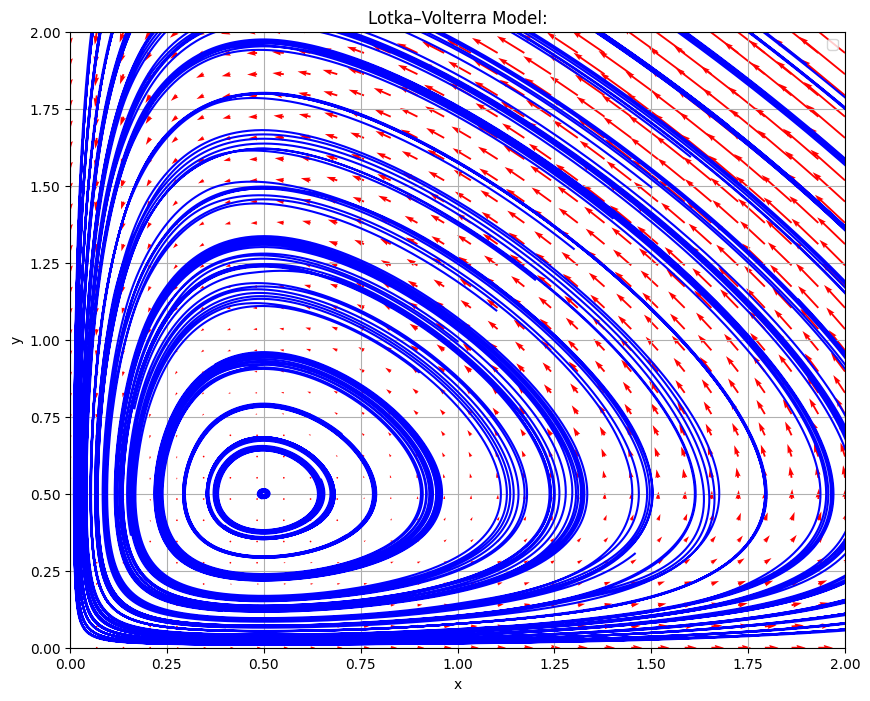

In [53]:
inicial = [(i*0.1, (i-0.05)*0.1) for i in range(20)]
print(inicial)

diagrama_fases(A, [x, y],
              {param[0]: 0.5, param[1]: 1, param[2]: 0.5, param[3]: 1},
               title="Lotka–Volterra Model:",
               limx=(0,2), limy=(0,2), n=30,
               inicial=inicial, m=1000)

### Lotka–Volterra cargo capacity Model:

El modelo de Lotka-Volterra con capacidad de carga proporciona una perspectiva más realista de las interacciones depredador-presa al incorporar la limitación de recursos en el entorno. Este enfoque describe cómo las poblaciones de presa y depredador interactúan, considerando no solo la reproducción de la presa y la depredación, sino también los efectos de la capacidad de carga del hábitat. De esta manera, el modelo permite observar cómo las poblaciones fluctúan en respuesta a la disponibilidad de recursos y las interacciones entre ellas

$$
\begin{cases}
\dot{x} = x\left(a \left(1 - \frac{x}{K}\right) - by\right) \\
\dot{y} = y\left(-c + dx\right)
\end{cases}
$$

In [62]:
param = sp.symbols('a b c d K')  # Esto creará x_0, x_1, x_2, ..., x_4
x, y = sp.symbols('x y')
# Para verificar, puedes imprimir la lista

A = sp.Matrix([x*(param[0]*(1-(x/param[4]))-param[1]*y),
               y*(-param[2]+param[3]*x)])

#### Estabilidad del Modelo

sea

$$
F(x,y)
\begin{cases}
\dot{x} = x\left(a \left(1 - \frac{x}{K}\right) - by\right) \\
\dot{y} = y\left(-c + dx\right)
\end{cases}
$$

Primer paso hallar los ceros:

$$
F(x^*) = 0 \\
\begin{cases}
0 = x\left(a \left(1 - \frac{x}{K}\right) - by\right) \\
0 = y\left(-c + dx\right)
\end{cases}
$$

**Eq 1: $y = 0$** entonces

$
0 = x\left(a \left(1 - \frac{x}{K} \right) \right)
$

**Eq 1.1** $x = 0$. Entonces $x^* = (0, 0)$ \\
**Eq 1.2** $0 = a \left(1 - \frac{x}{K} \right) ⇒ 0 = 1 - \frac{x}{K} ⇒ x = K$. Entonces $x^* = (K, 0)$ \\

In [63]:
print(f"x = {solve_system(A, y, x, 0, index=0)}")

x = [0, K]


Eq 2: Si $x = \frac{c}{d}$, entonces \\
$
0 = \frac{c}{d}(a(1 - \frac{c}{dK})- by) ⇒ 0 = a(1 - \frac{c}{dK}) - by ⇒ y = \frac{a}{b} (1 - \frac{c}{dK}) ⇒ y = a \frac{dK-c}{bdK} \\
$

Por lo tanto, $x^* = \left(\frac{c}{d},  a \frac{dK-c}{bdK}\right)$

In [64]:
print(f"y = {solve_system(A, x, y, param[2]/param[3], index=0)}")

y = [a*(K*d - c)/(K*b*d)]



Segundo paso Jacobiana:

$$
J(x) = \begin{pmatrix}
a \left(1-\frac{x}{K}\right) - by - \frac{a}{K}x & -bx \\
dy & -c+dx
\end{pmatrix}
$$

In [65]:
JB = A.jacobian([x, y])
sp.pprint(JB)

⎡  ⎛    x⎞         a⋅x          ⎤
⎢a⋅⎜1 - ─⎟ - b⋅y - ───    -b⋅x  ⎥
⎢  ⎝    K⎠          K           ⎥
⎢                               ⎥
⎣         d⋅y           -c + d⋅x⎦


Tercer paso hallar autovalores de todos los $x^*$ $det(J(x^*) - λI) = 0$

Con $x^* = (0, 0)$

$$
det(J(0,0) - λI) = det\left( \begin{pmatrix}
a - λ& 0 \\
0 & -c - λ
\end{pmatrix}\right)
$$

donde $ λ_1 = a ∧ λ_2 = -c$. Por casos:

1.   Si $a ∧ c ∈ R^+$ Como algunos valores propios tienen parte real negativa y otros positivos, entonces es una silla.
2.   Si $a ∈ R^+ ∧ c ∈ R^-$ Como todos los valores propios tienen parte real positivos, entonces es un nodo inestable.
3.   Si $a ∈ R^- ∧ c ∈ R^+$ Como todos los valores propios tienen parte real neagtiva, entonces es un nodo estable.
4.   Si $a ∧ c ∈ R^-$ Como algunos valores propios tienen parte real negativa y otros positivos, entonces es un punto silla.


In [66]:
print(eigen_values_symbolic(A, param, [x, y], [0, 0]))
print(eigen_values_symbolic(A, param, [x, y], [0, 0], eval={param[0]:1, param[2]:1}))
print(eigen_values_symbolic(A, param, [x, y], [0, 0], eval={param[0]:1, param[2]:-1}))
print(eigen_values_symbolic(A, param, [x, y], [0, 0], eval={param[0]:-1, param[2]:1}))
print(eigen_values_symbolic(A, param, [x, y], [0, 0], eval={param[0]:-1, param[2]:-1}))

{a: 1, -c: 1}
{1: 1, -1: 1}
{1: 2}
{-1: 2}
{-1: 1, 1: 1}



Con $x^* = \left(K, 0\right)$

$$
det\left(J\left(\frac{c}{d}, \frac{a}{b}\right) - λI\right) = det\left(
\begin{pmatrix}
-a-λ & -bK \\
0 & dK-c-λ
\end{pmatrix}
\right)
$$

donde $ λ_1 = dK-c ∧ λ_2 = -a$. Asumiendo $a > 0$ entonces:
1.   $dK-c > 0$. Como algunos valores propios tienen parte real negativa y otros positivos, entonces es una silla
2.   $dK-c < 0$. Como los dos valores propios tiene parte real negativa, entonces es un nodo atractor.

In [67]:
print(eigen_values_symbolic(A, param, [x, y], [param[4], 0]))
print(eigen_values_symbolic(A, param, [x, y], [param[4], 0], eval={param[0]:1}))

{K*d - c: 1, -a: 1}
{K*d - c: 1, -1: 1}



Con $x^* = \left(\frac{c}{d},  a \frac{dK-c}{bdK}\right)$

$$
det\left(J\left(\frac{c}{d},  a \frac{dK-c}{bdK}\right) - λI\right) = det\left(
\begin{pmatrix}
a - \frac{a(dK-c)}{dK} - λ & -\frac{bc}{d} \\
\frac{a(dK-c)}{bK} & - λ
\end{pmatrix}
\right)
$$

donde $λ_1 = -\frac{ac}{2dK} - \frac{\sqrt{ac(-4d^2K^2+4cdK+ac)}}{2dK} ∧ λ_2 = -\frac{ac}{2dK} + \frac{\sqrt{ac(-4d^2K^2+4cdK+ac)}}{2dK}$


In [70]:
x_eval = param[2]/param[3]
y_eval = param[0]*((param[3]*param[4]-param[2])/(param[3]*param[4]*param[1]))

eval = {param[0]:2, param[1]:1.2, param[2]:0.5, param[3]:0.8, param[4]:1}

print(eigen_values_symbolic(A, param, [x, y], [x_eval, y_eval]))
print(eigen_values_symbolic(A, param, [x, y], [x_eval, y_eval], eval=eval))

{-a*c/(2*K*d) - sqrt(a*c*(-4*K**2*d**2 + 4*K*c*d + a*c))/(2*K*d): 1, -a*c/(2*K*d) + sqrt(a*c*(-4*K**2*d**2 + 4*K*c*d + a*c))/(2*K*d): 1}
{-0.750000000000000: 1, -0.500000000000000: 1}


#### Diagrama de fase

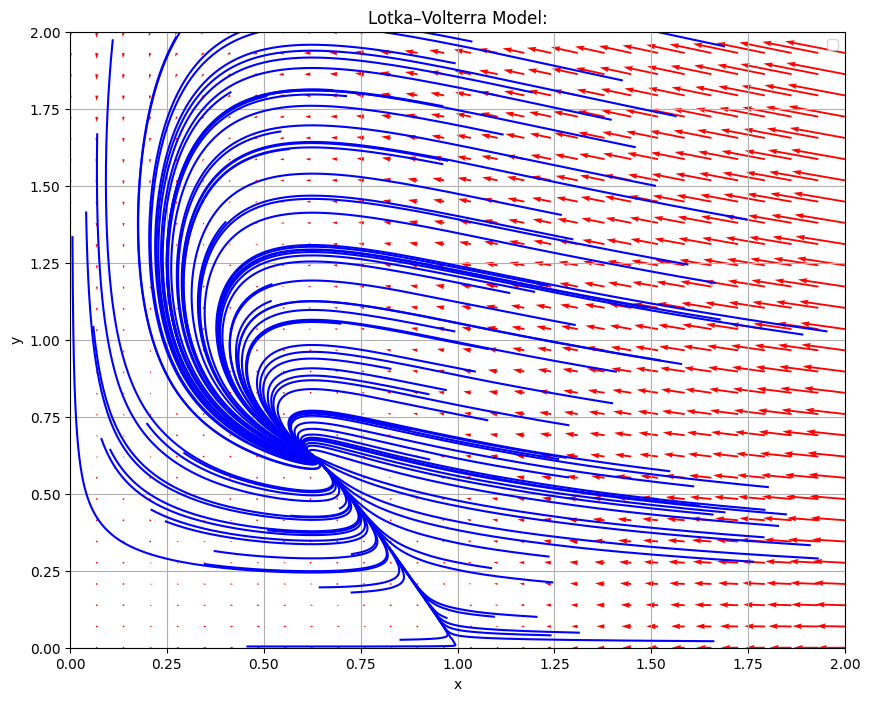

In [71]:
limx = (0,2)
limy = (0,2)

inicial = [(uniform(limx[0], limx[1]), uniform(limy[0], limy[1])) for _ in range(100)]

diagrama_fases(A, [x, y],
               eval,
               title="Lotka–Volterra Model:",
               limx=limx, limy=limy, n=30,
               inicial=inicial, m=1000)

### Allee Effect Model

El efecto Allee ocurre cuando las densidades de población de la presa son tan bajas que impiden su supervivencia o reproducción. En sistemas con un fuerte efecto Allee, las poblaciones por debajo de un umbral crítico colapsarán. Este efecto desestabiliza los equilibrios, ralentiza la convergencia del sistema al equilibrio e influye en el comportamiento poblacional a largo plazo. Los modelos modificados de Lotka-Volterra incorporan el efecto Allee, lo que lleva a escenarios donde la presa podría enfrentar la extinción si su población cae por debajo del umbral.

En términos matemáticos, el efecto Allee se representa habitualmente al alterar la función de crecimiento. La modificación más común consiste en aplicar un factor multiplicativo, obteniendo para una sola especia

$$
\dot{x} = r\left(1- \frac{x}{K}\right)(x-m)x \\
$$

en esta ecuación, r representa la tasa de crecimiento intrínseca y K indica la capacidad de carga del entorno. El efecto Allee se considera fuerte cuando $m>0$ y débil cuando $m≤0$. En el caso del efecto Allee fuerte, la tasa de crecimiento por individuo es negativa para valores de x entre 0 y m, lo que sugiere que la población puede extinguirse.

Un modelo general para la inclusión del efecto alley en los modelos presa depredador viene dado por el sistem
$$
\begin{cases}
\dot{x}=g(x)(f(x)-y)\\
\dot{y}=y(g(x)-d)
\end{cases}
$$
donde la función g es la respuesta funcional del depredador y g(x)f(x) es la tasa de crecimiento neto de la presa.

Al igual que en el docuemnto se realizara el analisis de dos sistemas con el efecto alley, uno con doble efecto \\
$
\begin{cases}
\dot{x}=x\left(\frac{r}{x+n}\left(1-\frac{x}{K}\right)(x-m)-qy\right)\\
\dot{y}=y(px-c)
\end{cases}
$ \\
y otro con un simple efecto \\
$
\begin{cases}
\dot{x}=x\left(r\left(1-\frac{x}{K}\right)(x-m)-qy\right)\\
\dot{y}=y(px-c)
\end{cases}
$

In [134]:
param = sp.symbols('r K m n q p c')  # Esto creará x_0, x_1, x_2, ..., x_4
x, y = sp.symbols('x y')
# Para verificar, puedes imprimir la lista

A = sp.Matrix([x*((param[0]/(x+param[3]))*(1-(x/param[1]))*(x-param[2]) - param[4]*y),
               y*(param[5]*x - param[6])])
B = sp.Matrix([x*((param[0])*(1-(x/param[1]))*(x-param[2]) - param[4]*y),
               y*(param[5]*x - param[6])])

eval = {param[0]:2, param[1]:1, param[2]:-2, param[3]:2, param[4]:1.2, param[5]:0.8, param[6]:0.5}

#### Estabilidad del Modelo 1

sea

$$
F(x,y) =
\begin{cases}
\dot{x}=x\left(\frac{r}{x+n}\left(1-\frac{x}{K}\right)(x-m)-qy\right)\\
\dot{y}=y(px-c)
\end{cases}
$$

Primer paso hallar los ceros:

$$
F(x^*) = 0 \\
\begin{cases}
0=x\left(\frac{r}{x+n}\left(1-\frac{x}{K}\right)(x-m)-qy\right)\\
0=y(px-c)
\end{cases}
$$

**Eq 1: $y = 0$** entonces

$
0 = x\left(\frac{r}{x+n}\left(1-\frac{x}{K}\right)(x-m)\right)
$

**Eq 1.1** $x = 0$. Entonces $x^* = (0, 0)$ \\
**Eq 1.2** $0 = 1-\frac{x}{K} ⇒ x = K$ $x^* = (K, 0)$ \\
**Eq 1.3** $0 = x-m ⇒  x = m$. Entonces $x^* = (m, 0)$ \\


In [135]:
print(f"x = {solve_system(A, y, x, 0, index=0)}")

x = [0, K, m]


**Eq 2: si $x = \frac{c}{p}$** entonces

$
0=\frac{c}{p} \left(\frac{rp}{c+pn}\left(1-\frac{c}{pK}\right)\left(\frac{c}{p}-m\right)-qy\right) \\
0 = \frac{rp}{c+pn}\left(\frac{pK-c}{pK}\right)\left(\frac{c-pm}{p}\right)-qy\\
qy = \frac{r}{pK(c+pn)}\left(pcK-p^2mK +pcm-c^2 \right)\\
y = \frac{r}{pqK(c+pn)}\left(pcK-p^2mK +pcm-c^2 \right)
$

Por lo tanto $x^* = \left( \frac{c}{p}, \frac{r}{pqK(c+pn)}\left(pcK-p^2mK +pcm-c^2\right)\right)$

In [136]:
print(f"x = {solve_system(A, x, y, param[6]/param[5], index=0)}")

x = [r*(K*c*p - K*m*p**2 - c**2 + c*m*p)/(K*p*q*(c + n*p))]



Segundo paso Jacobiana:

$$
J(x) = \begin{pmatrix}
\frac{r}{n+x}\left(1-\frac{x}{K} \right)(x-m)+x\left(\frac{r}{(n+x)^2}\left( 1-\frac{x}{K}\right)(x-m)+\frac{r}{n+x}\left( 1-\frac{x}{K}\right) - \frac{r}{(n+x)K}(x-m)\right) -qy & -qx \\
py & -c+px
\end{pmatrix}
$$

In [137]:
JB = A.jacobian([x, y])
sp.pprint(JB)

⎡         ⎛    x⎞              ⎛    ⎛    x⎞              ⎛    x⎞             ⎞          ⎤
⎢       r⋅⎜1 - ─⎟⋅(-m + x)     ⎜  r⋅⎜1 - ─⎟⋅(-m + x)   r⋅⎜1 - ─⎟             ⎟          ⎥
⎢         ⎝    K⎠              ⎜    ⎝    K⎠              ⎝    K⎠   r⋅(-m + x)⎟          ⎥
⎢-q⋅y + ────────────────── + x⋅⎜- ────────────────── + ───────── - ──────────⎟    -q⋅x  ⎥
⎢             n + x            ⎜              2          n + x     K⋅(n + x) ⎟          ⎥
⎢                              ⎝       (n + x)                               ⎠          ⎥
⎢                                                                                       ⎥
⎣                                     p⋅y                                       -c + p⋅x⎦


Tercer paso hallar autovalores de todos los $x^*$ $det(J(x^*) - λI) = 0$

Con $x^* = (0, 0)$

$$
det(J(0,0) - λI) = det\left( \begin{pmatrix}
-\frac{mr}{n}-λ & 0 \\
0 & -c-λ
\end{pmatrix}\right)
$$

donde $ λ_1 = -\frac{mr}{n} ∧ λ_2 = -c$. si c > 0:
1.   $\frac{mr}{n} < 0$. Como algunos valores propios tienen parte real negativa y otros positivos, entonces es una silla
2.   $\frac{mr}{n} > 0$. Como los dos valores propios tiene parte real negativa, entonces es un nodo atractor.



In [138]:
sp.pprint(JB.subs({x:0, y:0}))

print(eigen_values_symbolic(A, param, [x, y], [0, 0]))
print(eigen_values_symbolic(A, param, [x, y], [0, 0], eval={param[6]:1}))

⎡-m⋅r     ⎤
⎢─────  0 ⎥
⎢  n      ⎥
⎢         ⎥
⎣  0    -c⎦
{-m*r/n: 1, -c: 1}
{-m*r/n: 1, -1: 1}



Con $x^* = \left(K, 0\right)$

$$
det\left(J\left(K, 0\right) - λI\right) = det\left(
\begin{pmatrix}
r\frac{m-K}{n+K}-λ & -qK \\
0 & pK-c-λ
\end{pmatrix}
\right)
$$

donde $ λ_1 =r\frac{m-K}{n+K} ∧ λ_2 = pK-c$. Por casos:

In [139]:
sp.pprint(JB.subs({x:param[1], y:0}))

print(eigen_values_symbolic(A, param, [x, y], [param[1], 0]))
print(eigen_values_symbolic(A, param, [x, y], [param[1], 0], eval=eval))

⎡-r⋅(K - m)          ⎤
⎢───────────   -K⋅q  ⎥
⎢   K + n            ⎥
⎢                    ⎥
⎣     0       K⋅p - c⎦
{K*p - c: 1, r*(-K + m)/(K + n): 1}
{-2.00000000000000: 1, 0.300000000000000: 1}



Con $x^* = \left(M, 0\right)$

$$
det\left(J\left(M, 0\right) - λI\right) = det\left(
\begin{pmatrix}
rm\frac{K-m}{K(m+n)}-λ & -qm \\
0 & mp-c-λ
\end{pmatrix}
\right)
$$

donde $ λ_1 = rm\frac{K-m}{K(m+n)} ∧ λ_2 = mp-c$.

In [140]:
sp.pprint(JB.subs({x:param[2], y:0}))

eval1 = {param[0]:2, param[1]:1, param[3]:2, param[4]:1.2, param[5]:0.8, param[6]:0.5}

print(eigen_values_symbolic(A, param, [x, y], [param[2], 0]))
print(eigen_values_symbolic(A, param, [x, y], [param[2], 0], eval=eval1))

⎡    ⎛    m⎞          ⎤
⎢m⋅r⋅⎜1 - ─⎟          ⎥
⎢    ⎝    K⎠          ⎥
⎢───────────    -m⋅q  ⎥
⎢   m + n             ⎥
⎢                     ⎥
⎣     0       -c + m⋅p⎦
{-c + m*p: 1, -m*r*(-K + m)/(K*(m + n)): 1}
{0.8*(1.0*m - 0.625): 1, -2*m*(m - 1)/(m + 2): 1}



Con $x^* = \left( \frac{c}{p}, \frac{r}{pqK(c+pn)}\left(pcK-p^2mK +pcm-c^2\right)\right)$

$$
det\left(J\left( \frac{c}{p}, \frac{r}{pqK(c+pn)}\left(pcK-p^2mK +pcm-c^2\right)\right) - λI\right)
$$

Al resultado ofrecido por en la evualición con valores propios $λ_1 ∧ λ_2$

In [141]:
print(param)

x_val = param[6]/param[5]
y_val = (param[0]/(param[5]*param[4]*param[1]*(param[6]+param[5]*param[3]))) * (param[5]*param[6]*param[1]-(param[5]**2)*param[2]*param[1]+param[5]*param[6]*param[2]-(param[6]**2))

sp.pprint(JB.subs({x:x_val, y:y_val}))

print(eigen_values_symbolic(A, param, [x, y], [x_val, y_val]))
print(eigen_values_symbolic(A, param, [x, y], [x_val, y_val], eval=eval))

(r, K, m, n, q, p, c)
⎡  ⎛    ⎛     c ⎞ ⎛c    ⎞     ⎛     c ⎞     ⎛c    ⎞⎞                                               ↪
⎢  ⎜  r⋅⎜1 - ───⎟⋅⎜─ - m⎟   r⋅⎜1 - ───⎟   r⋅⎜─ - m⎟⎟                                               ↪
⎢  ⎜    ⎝    K⋅p⎠ ⎝p    ⎠     ⎝    K⋅p⎠     ⎝p    ⎠⎟                                               ↪
⎢c⋅⎜- ─────────────────── + ─────────── - ─────────⎟                                               ↪
⎢  ⎜              2            c            ⎛c    ⎞⎟                                               ↪
⎢  ⎜       ⎛c    ⎞             ─ + n      K⋅⎜─ + n⎟⎟     ⎛     c ⎞ ⎛c    ⎞                         ↪
⎢  ⎜       ⎜─ + n⎟             p            ⎝p    ⎠⎟   r⋅⎜1 - ───⎟⋅⎜─ - m⎟     ⎛             2     ↪
⎢  ⎝       ⎝p    ⎠                                 ⎠     ⎝    K⋅p⎠ ⎝p    ⎠   r⋅⎝K⋅c⋅p - K⋅m⋅p  - c ↪
⎢─────────────────────────────────────────────────── + ─────────────────── - ───────────────────── ↪
⎢                         p                                   c      

#### Estabilidad del Modelo 2

sea

$$
F(x,y) =
\begin{cases}
\dot{x}=x\left(r\left(1-\frac{x}{K}\right)(x-m)-qy\right)\\
\dot{y}=y(px-c)
\end{cases}
$$

Primer paso hallar los ceros:

$$
F(x^*) = 0 \\
\begin{cases}
0=x\left(r\left(1-\frac{x}{K}\right)(x-m)-qy\right)\\
0=y(px-c)
\end{cases}
$$

**Eq 1: $y = 0$** entonces

$
0 = x\left(r\left(1-\frac{x}{K}\right)(x-m)\right)
$

**Eq 1.1** $x = 0$. Entonces $x^* = (0, 0)$ \\
**Eq 1.2** $0 = 1-\frac{x}{K} ⇒ x = K$ $x^* = (K, 0)$ \\
**Eq 1.3** $0 = x-m ⇒  x = m$. Entonces $x^* = (m, 0)$ \\


In [142]:
print(f"x = {solve_system(B, y, x, 0, index=0)}")

x = [0, K, m]


**Eq 2: si $x = \frac{c}{p}$** entonces

$
0=\frac{c}{p} \left(r\left(1-\frac{c}{pK}\right)\left(\frac{c}{p}-m\right)-qy\right) \\
0 = r\left(\frac{pK-c}{pK}\right)\left(\frac{c-pm}{p}\right)-qy\\
qy = \frac{r}{p^2K}\left(pcK-p^2mK +pcm-c^2 \right)\\
y = \frac{r}{p^2qK}\left(pcK-p^2mK +pcm-c^2 \right)
$

Por lo tanto $x^* = \left( \frac{c}{p}, \frac{r}{p^2qK}\left(pcK-p^2mK +pcm-c^2\right)\right)$

In [143]:
print(f"x = {solve_system(B, x, y, param[6]/param[5], index=0)}")

x = [r*(K*c*p - K*m*p**2 - c**2 + c*m*p)/(K*p**2*q)]



Segundo paso Jacobiana:

$$
J(x) = \begin{pmatrix}
r\left(1-\frac{x}{K} \right)(x-m)+xr\left(\left( 1-\frac{x}{K}\right)\frac{r(x-m)}{K} \right) -qy & -qx \\
py & -c+px
\end{pmatrix}
$$

In [144]:
JB = B.jacobian([x, y])
sp.pprint(JB)

⎡         ⎛    x⎞              ⎛  ⎛    x⎞   r⋅(-m + x)⎞          ⎤
⎢-q⋅y + r⋅⎜1 - ─⎟⋅(-m + x) + x⋅⎜r⋅⎜1 - ─⎟ - ──────────⎟    -q⋅x  ⎥
⎢         ⎝    K⎠              ⎝  ⎝    K⎠       K     ⎠          ⎥
⎢                                                                ⎥
⎣                         p⋅y                            -c + p⋅x⎦


Tercer paso hallar autovalores de todos los $x^*$ $det(J(x^*) - λI) = 0$

Con $x^* = (0, 0)$

$$
det(J(0,0) - λI) = det\left( \begin{pmatrix}
-mr-λ & 0 \\
0 & -c-λ
\end{pmatrix}\right)
$$

donde $ λ_1 = -mr ∧ λ_2 = -c$. si c > 0:
1.   $mr < 0$. Como algunos valores propios tienen parte real negativa y otros positivos, entonces es una silla
2.   $mr > 0$. Como los dos valores propios tiene parte real negativa, entonces es un nodo atractor.



In [145]:
sp.pprint(JB.subs({x:0, y:0}))

print(eigen_values_symbolic(B, param, [x, y], [0, 0]))
print(eigen_values_symbolic(B, param, [x, y], [0, 0], eval={param[6]:1}))

⎡-m⋅r  0 ⎤
⎢        ⎥
⎣ 0    -c⎦
{-m*r: 1, -c: 1}
{-m*r: 1, -1: 1}



Con $x^* = \left(K, 0\right)$

$$
det\left(J\left(K, 0\right) - λI\right) = det\left(
\begin{pmatrix}
r(m-K)-λ & -qK \\
0 & pK-c-λ
\end{pmatrix}
\right)
$$

donde $ λ_1 =r(m-K) ∧ λ_2 = pK-c$.

In [146]:
sp.pprint(JB.subs({x:param[1], y:0}))

print(eigen_values_symbolic(B, param, [x, y], [param[1], 0]))
print(eigen_values_symbolic(B, param, [x, y], [param[1], 0], eval=eval))

⎡-r⋅(K - m)   -K⋅q  ⎤
⎢                   ⎥
⎣    0       K⋅p - c⎦
{K*p - c: 1, r*(-K + m): 1}
{-6.00000000000000: 1, 0.300000000000000: 1}



Con $x^* = \left(M, 0\right)$

$$
det\left(J\left(M, 0\right) - λI\right) = det\left(
\begin{pmatrix}
rm\frac{K-m}{K}-λ & -qm \\
0 & mp-c-λ
\end{pmatrix}
\right)
$$

donde $ λ_1 = rm\frac{K-m}{K} ∧ λ_2 = mp-c$.

In [147]:
sp.pprint(JB.subs({x:param[2], y:0}))

eval1 = {param[0]:2, param[1]:1, param[3]:2, param[4]:1.2, param[5]:0.8, param[6]:0.5}

print(eigen_values_symbolic(B, param, [x, y], [param[2], 0]))
print(eigen_values_symbolic(B, param, [x, y], [param[2], 0], eval=eval1))

⎡    ⎛    m⎞          ⎤
⎢m⋅r⋅⎜1 - ─⎟    -m⋅q  ⎥
⎢    ⎝    K⎠          ⎥
⎢                     ⎥
⎣     0       -c + m⋅p⎦
{-c + m*p: 1, -m*r*(-K + m)/K: 1}
{0.8*(1.0*m - 0.625): 1, -2*m*(m - 1): 1}



Con $x^* = \left( \frac{c}{p}, \left( \frac{c}{p}, \frac{r}{p^2qK}\left(pcK-p^2mK +pcm-c^2\right)\right)\right)$

$$
det\left(J\left( \frac{c}{p},  \frac{r}{p^2qK}\left(pcK-p^2mK +pcm-c^2\right)\right) - λI\right)
$$

Al resultado ofrecido por en la evualición con valores propios $λ_1 ∧ λ_2$

In [148]:
print(param)

x_val = param[6]/param[5]
y_val = (param[0]/((param[5]**2)*param[4]*param[1])) * (param[5]*param[6]*param[1]-(param[5]**2)*param[2]*param[1]+param[5]*param[6]*param[2]-(param[6]**2))

sp.pprint(JB.subs({x:x_val, y:y_val}))

print(eigen_values_symbolic(B, param, [x, y], [x_val, y_val]))
print(eigen_values_symbolic(B, param, [x, y], [x_val, y_val], eval=eval))

(r, K, m, n, q, p, c)
⎡  ⎛                ⎛c    ⎞⎞                                                               ⎤
⎢  ⎜              r⋅⎜─ - m⎟⎟                                                               ⎥
⎢  ⎜  ⎛     c ⎞     ⎝p    ⎠⎟                                                               ⎥
⎢c⋅⎜r⋅⎜1 - ───⎟ - ─────────⎟                           ⎛             2    2        ⎞       ⎥
⎢  ⎝  ⎝    K⋅p⎠       K    ⎠     ⎛     c ⎞ ⎛c    ⎞   r⋅⎝K⋅c⋅p - K⋅m⋅p  - c  + c⋅m⋅p⎠  -c⋅q ⎥
⎢─────────────────────────── + r⋅⎜1 - ───⎟⋅⎜─ - m⎟ - ───────────────────────────────  ─────⎥
⎢             p                  ⎝    K⋅p⎠ ⎝p    ⎠                   2                  p  ⎥
⎢                                                                 K⋅p                      ⎥
⎢                                                                                          ⎥
⎢                            ⎛             2    2        ⎞                                 ⎥
⎢                          r⋅⎝K⋅c⋅p - K⋅m⋅p  - c

#### Diagrama de fase

##### Diagramas de fase para el primer conjunto de parametros

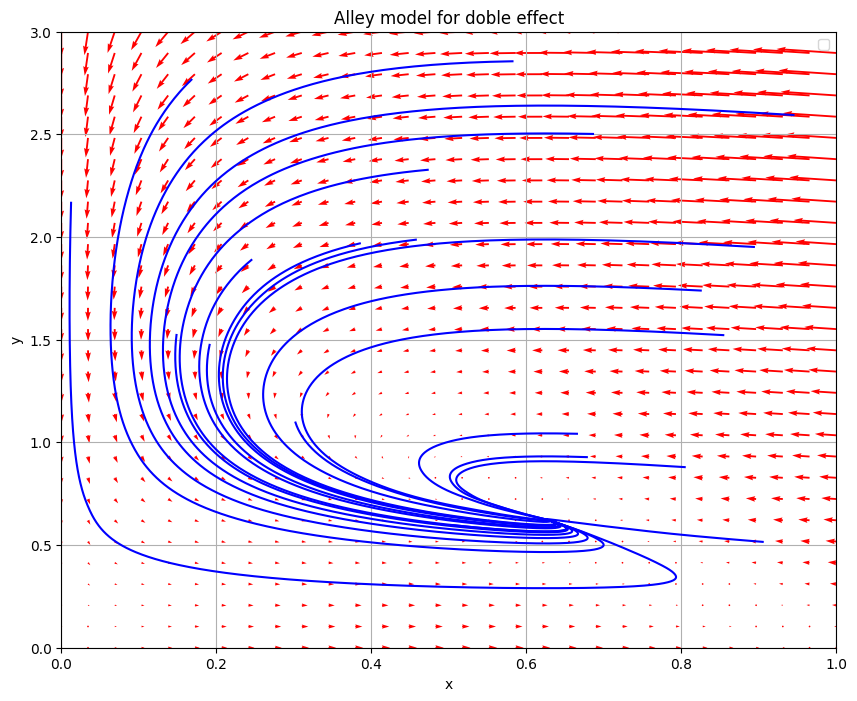

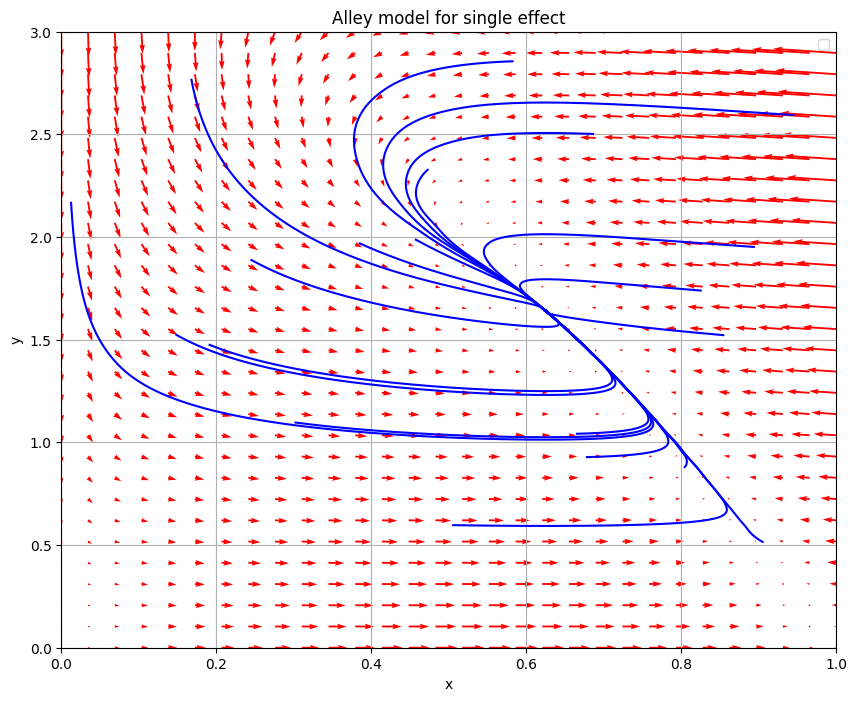

In [155]:
eval = {param[0]:2, param[1]:1, param[2]:-2, param[3]:2, param[4]:1.2, param[5]:0.8, param[6]:0.5}

limx = (0,1)
limy = (0,3)

inicial = [(uniform(limx[0], limx[1]), uniform(limy[0], limy[1])) for _ in range(20)]

diagrama_fases(A, [x, y],
               eval,
               title="Alley model for doble effect",
               limx=limx, limy=limy, n=30,
               inicial=inicial, m=1000)
diagrama_fases(B, [x, y],
               eval,
               title="Alley model for single effect",
               limx=limx, limy=limy, n=30,
               inicial=inicial, m=1000)

##### Diagramas de fase para el segundo conjunto de parametros

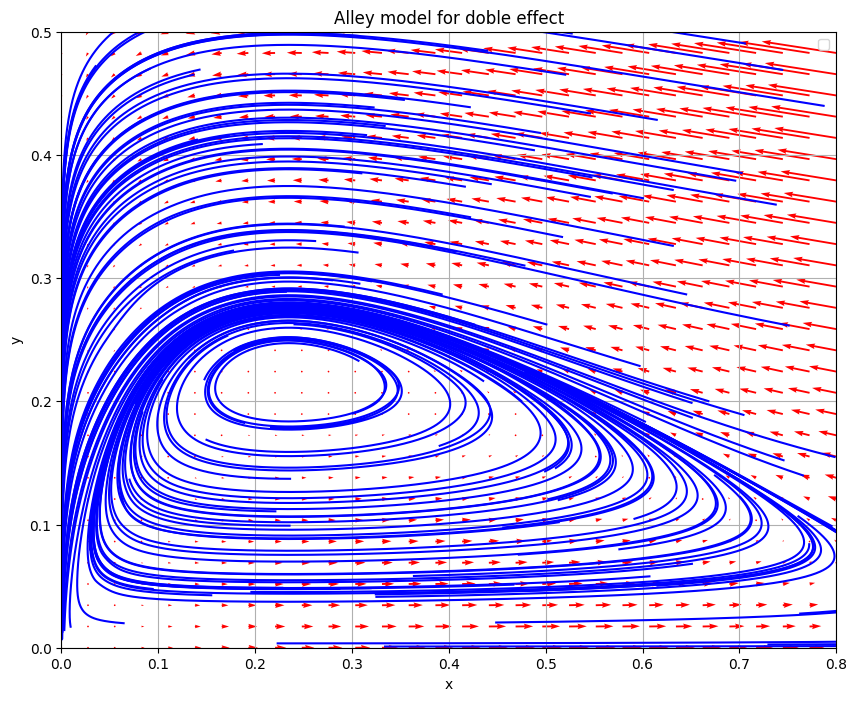

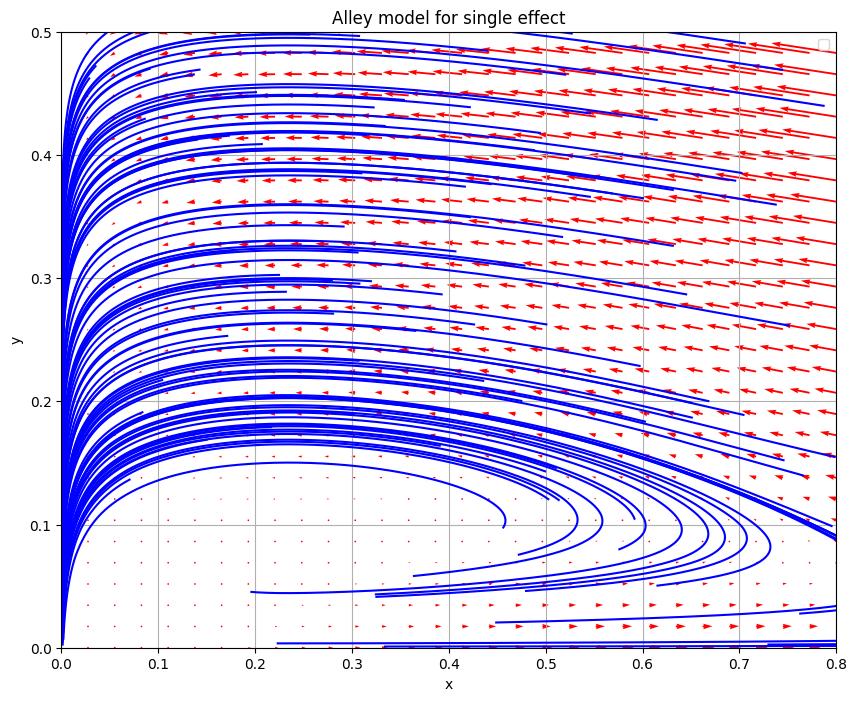

In [158]:
eval = {param[0]:0.5, param[1]:1, param[2]:0.001, param[3]:0.10375, param[4]:1.2, param[5]:0.175, param[6]:0.041125}

limx = (0,0.8)
limy = (0,0.5)

inicial = [(uniform(limx[0], limx[1]), uniform(limy[0], limy[1])) for _ in range(100)]

diagrama_fases(A, [x, y],
               eval,
               title="Alley model for doble effect",
               limx=limx, limy=limy, n=30,
               inicial=inicial, m=1000)
diagrama_fases(B, [x, y],
               eval,
               title="Alley model for single effect",
               limx=limx, limy=limy, n=30,
               inicial=inicial, m=1000)

### Fear Effect Model

En un sistema biológico donde coexisten depredadores y presas, el comportamiento de cada una de estas especies puede afectar a ambas poblaciones. La forma de vida de la presa influye en la evolución del ecosistema; por ejemplo, cuando las presas, al darse cuenta de la presencia de sus depredadores, sienten miedo y actúan en consecuencia, lo que dificulta la caza para los depredadores. Este hecho impulsa a las presas a evitar la depredación directa, lo que puede aumentar su supervivencia a corto plazo, pero podría resultar en una disminución a largo plazo de la población de presas como consecuencia.

En términos matemáticos, la modificación del efecto del miedo integra la idea de que las presas exhiben comportamientos anti-depredador en respuesta a la presencia de depredadores, lo que afecta su reproducción y búsqueda de alimento. Un modelo propuesto por X. Wang, L. Zannete y X. Zou es:

$$
\begin{cases}
\dot{x} &= r x f(s, y) - d x - a x^2 - g(x) y, \\
\dot{y} &= y(-n + c g(x)).
\end{cases}
$$

donde la función $f(s,y)$ está relacionada con el costo de la defensa anti-depredador debido al miedo, y el parámetro s representa el nivel de miedo.

Al igual que en el modelo anterios se realizara el analisis de dos sistemas. El primero es un modelo en el que se reduce la tasa de crecimiento de la presa debido al efecto del miedo, y donde la presa también está afectada por un efecto Allee \\
$
\begin{cases}
\dot{x} &= x \left(r \left(1 - \frac{x}{K}\right)(x - m) \frac{1}{1 + sy} - ay\right) \\
\dot{y} &= y(a \alpha x - n).
\end{cases}
$ \\
donde s representa el efecto del miedo y m el efecto Allee. Y el segundo
donde reemplazaron el efecto Allee usual con un efecto Allee aditivo. Su sistema se describe como: \\
$
\begin{cases}
\dot{x} &= x \left(r \left(1 - x - \frac{m}{x + b}\right) \frac{1}{1 + sy} - ay\right) \\
\dot{y} &= y(a \alpha x - n)
\end{cases}
$ \\
donde el término $\frac{1}{1 + sy}$ representa el efecto del miedo y $\frac{m}{x + b}$ representa el efecto Allee aditivo. En particular, los valores de s y m representan, respectivamente, la intensidad del efecto del miedo y el efecto Alle \\


In [177]:
r, K, m, s, a, alpha, n, b = sp.symbols('r K m s a alpha n b')  # Esto creará x_0, x_1, x_2, ..., x_4
param = [r, K, m, s, a, alpha, n, b]
x, y = sp.symbols('x y')
# Para verificar, puedes imprimir la lista

A = sp.Matrix([x*(r*(1-(x/K))*(x-m)*(1/(1+s*y)) - a*y),
               y*(a*alpha*x-n)])
B = sp.Matrix([x*(r*(1-x-(m/(x+b)))*(1/(1+s*y)) - a*y),
               y*(a*alpha*x-n)])

eval = {r:1, m:0.25, s:1.5, a:1, K:1, alpha:0.5, n:0.12, b:20}

#### Estabilidad del Modelo 1

sea

$$
F(x,y) =
\begin{cases}
\dot{x} &= x \left(r \left(1 - \frac{x}{K}\right)(x - m) \frac{1}{1 + sy} - ay\right) \\
\dot{y} &= y(a \alpha x - n).
\end{cases}
$$

Primer paso hallar los ceros:

$$
F(x^*) = 0 \\
\begin{cases}
0 &= x \left(r \left(1 - \frac{x}{K}\right)(x - m) \frac{1}{1 + sy} - ay\right) \\
0 &= y(a \alpha x - n).
\end{cases}
$$

**Eq 1: $y = 0$** entonces

$
0 = x \left(r \left(1 - \frac{x}{K}\right)(x - m) \frac{1}{1 + sy}\right)
$

**Eq 1.1** $x = 0$. Entonces $x^* = (0, 0)$ \\
**Eq 1.2** $x = K$. Entonces $x^* = (K, 0)$ \\
**Eq 1.3** $x = m$. Entonces $x^* = (m, 0)$ \\


In [178]:
print(f"x = {solve_system(A, y, x, 0, index=0)}")

x = [0, K, m]


**Eq 2: si $x = \frac{n}{a \alpha}$** entonces

**Eq 1.1** $y = \frac{-K a^3 \alpha - \sqrt{K a^3 \left( K a^3 \alpha^2 - 4 K a^2 \alpha^2 m r s + 4 K a \alpha n r s + 4 a \alpha m n r s - 4 n^2 r s \right)}}{2 K a^3 \alpha s}$. Entonces $x^* = \left(\frac{n}{a \alpha}, \frac{-K a^3 \alpha - \sqrt{K a^3 \left( K a^3 \alpha^2 - 4 K a^2 \alpha^2 m r s + 4 K a \alpha n r s + 4 a \alpha m n r s - 4 n^2 r s \right)}}{2 K a^3 \alpha s}\right)$ \\
**Eq 1.2** $y = \frac{-K a^3 \alpha + \sqrt{K a^3 \left( K a^3 \alpha^2 - 4 K a^2 \alpha^2 m r s + 4 K a \alpha n r s + 4 a \alpha m n r s - 4 n^2 r s \right)}}{2 K a^3 \alpha s}$. Entonces $x^* = \left(\frac{n}{a \alpha}, \frac{-K a^3 \alpha + \sqrt{K a^3 \left( K a^3 \alpha^2 - 4 K a^2 \alpha^2 m r s + 4 K a \alpha n r s + 4 a \alpha m n r s - 4 n^2 r s \right)}}{2 K a^3 \alpha s}\right)$ \\

In [179]:
print(f"y = {solve_system(A, x, y, n/(a*alpha), index=0)}")

y = [(-K*a**3*alpha - sqrt(K*a**3*(K*a**3*alpha**2 - 4*K*a**2*alpha**2*m*r*s + 4*K*a*alpha*n*r*s + 4*a*alpha*m*n*r*s - 4*n**2*r*s)))/(2*K*a**3*alpha*s), (-K*a**3*alpha + sqrt(K*a**3*(K*a**3*alpha**2 - 4*K*a**2*alpha**2*m*r*s + 4*K*a*alpha*n*r*s + 4*a*alpha*m*n*r*s - 4*n**2*r*s)))/(2*K*a**3*alpha*s)]



Segundo paso Jacobiana:

$$
J(x) = \begin{pmatrix}
-a y + r \left(1 - \frac{x}{K}\right) \frac{-m + x}{s y + 1} + x \left( \frac{r \left(1 - \frac{x}{K}\right)}{s y + 1} - \frac{r(-m + x)}{K(s y + 1)} \right) & x \left(-a - \frac{r s \left(1 - \frac{x}{K}\right)(-m + x)}{(s y + 1)^2}\right) \\
a \alpha y & a \alpha x - n
\end{pmatrix}
$$

In [180]:
JB = A.jacobian([x, y])
sp.pprint(JB)

⎡         ⎛    x⎞              ⎛  ⎛    x⎞              ⎞    ⎛         ⎛    x⎞         ⎞⎤
⎢       r⋅⎜1 - ─⎟⋅(-m + x)     ⎜r⋅⎜1 - ─⎟              ⎟    ⎜     r⋅s⋅⎜1 - ─⎟⋅(-m + x)⎟⎥
⎢         ⎝    K⎠              ⎜  ⎝    K⎠   r⋅(-m + x) ⎟    ⎜         ⎝    K⎠         ⎟⎥
⎢-a⋅y + ────────────────── + x⋅⎜───────── - ───────────⎟  x⋅⎜-a - ────────────────────⎟⎥
⎢            s⋅y + 1           ⎝ s⋅y + 1    K⋅(s⋅y + 1)⎠    ⎜                   2     ⎟⎥
⎢                                                           ⎝          (s⋅y + 1)      ⎠⎥
⎢                                                                                      ⎥
⎣                         a⋅α⋅y                                     a⋅α⋅x - n          ⎦


Tercer paso hallar autovalores de todos los $x^*$ $det(J(x^*) - λI) = 0$

Con $x^* = (0, 0)$

$$
det(J(0,0) - λI) = det\left( \begin{pmatrix}
-m r - λ & 0 \\
0 & -n - λ
\end{pmatrix}
\right)
$$

donde $ λ_1 = -mr ∧ λ_2 = -n$. si n > 0:
1.   $ mr < 0$. Como algunos valores propios tienen parte real negativa y otros positivos, entonces es una silla
2.   $ mr > 0$. Como los dos valores propios tiene parte real negativa, entonces es un nodo atractor.



In [182]:
sp.pprint(JB.subs({x:0, y:0}))

print(eigen_values_symbolic(A, param, [x, y], [0, 0]))
print(eigen_values_symbolic(A, param, [x, y], [0, 0], eval={n:1}))

⎡-m⋅r  0 ⎤
⎢        ⎥
⎣ 0    -n⎦
{-m*r: 1, -n: 1}
{-m*r: 1, -1: 1}



Con $x^* = \left(K, 0\right)$

$$
det\left(J\left(K, 0\right) - λI\right) = det\left(
\begin{pmatrix}
-r(K - m)-λ & -K a \\
0 & K a \alpha - n-λ
\end{pmatrix}
\right)
$$

donde $ λ_1 = r(m - K) ∧ λ_2 = \alpha - n$.

In [183]:
sp.pprint(JB.subs({x:K, y:0}))

print(eigen_values_symbolic(A, param, [x, y], [K, 0]))
print(eigen_values_symbolic(A, param, [x, y], [K, 0], eval=eval))

⎡-r⋅(K - m)    -K⋅a   ⎤
⎢                     ⎥
⎣    0       K⋅a⋅α - n⎦
{K*a*alpha - n: 1, r*(-K + m): 1}
{-0.750000000000000: 1, 0.380000000000000: 1}



Con $x^* = \left(M, 0\right)$

$$
det\left(J\left(M, 0\right) - λI\right) = det\left(
\begin{pmatrix}
m r \left(1 - \frac{m}{K}\right) -λ & -a m \\
0 & a \alpha m - n -λ
\end{pmatrix}
\right)
$$

donde $ λ_1 = m r \left(1 - \frac{m}{K}\right) ∧ λ_2 = \alpha m - n$.

In [184]:
sp.pprint(JB.subs({x:m, y:0}))

print(eigen_values_symbolic(A, param, [x, y], [m, 0]))
print(eigen_values_symbolic(A, param, [x, y], [m, 0], eval=eval))

⎡    ⎛    m⎞           ⎤
⎢m⋅r⋅⎜1 - ─⎟    -a⋅m   ⎥
⎢    ⎝    K⎠           ⎥
⎢                      ⎥
⎣     0       a⋅α⋅m - n⎦
{a*alpha*m - n: 1, -m*r*(-K + m)/K: 1}
{0.187500000000000: 1, 0.00500000000000000: 1}



Con $x^* = \left(\frac{n}{a \alpha}, \frac{-K a^3 \alpha - \sqrt{K a^3 \left( K a^3 \alpha^2 - 4 K a^2 \alpha^2 m r s + 4 K a \alpha n r s + 4 a \alpha m n r s - 4 n^2 r s \right)}}{2 K a^3 \alpha s}\right)$

$$
det\left(J\left(\frac{n}{a \alpha}, \frac{-K a^3 \alpha - \sqrt{K a^3 \left( K a^3 \alpha^2 - 4 K a^2 \alpha^2 m r s + 4 K a \alpha n r s + 4 a \alpha m n r s - 4 n^2 r s \right)}}{2 K a^3 \alpha s}\right) - λI\right)
$$

Al resultado ofrecido por en la evualición con valores propios $λ_1 ∧ λ_2$

In [185]:
x_val = n/(a*alpha)
y_val = (-K*a**3*alpha - (K*a**3*(K*a**3*alpha**2 - 4*K*a**2*alpha**2*m*r*s + 4*K*a*alpha*n*r*s + 4*a*alpha*m*n*r*s - 4*n**2*r*s))**(1/2))/(2*K*a**3*alpha*s)

sp.pprint(JB.subs({x:x_val, y:y_val}))

print(eigen_values_symbolic(A, param, [x, y], [x_val, y_val]))
print(eigen_values_symbolic(A, param, [x, y], [x_val, y_val], eval=eval))

⎡                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                     ⎛      n  ⎞ ⎛      n ⎞                                       ↪
⎢                                   r⋅⎜1 - ─────⎟⋅⎜-m + ───⎟                               


Con $x^* = \left(\frac{n}{a \alpha}, \frac{-K a^3 \alpha + \sqrt{K a^3 \left( K a^3 \alpha^2 - 4 K a^2 \alpha^2 m r s + 4 K a \alpha n r s + 4 a \alpha m n r s - 4 n^2 r s \right)}}{2 K a^3 \alpha s}\right)$

$$
det\left(J\left( \frac{c}{p}, \frac{n}{a \alpha}, \frac{-K a^3 \alpha + \sqrt{K a^3 \left( K a^3 \alpha^2 - 4 K a^2 \alpha^2 m r s + 4 K a \alpha n r s + 4 a \alpha m n r s - 4 n^2 r s \right)}}{2 K a^3 \alpha s}\right) - λI\right)
$$

Al resultado ofrecido por en la evualición con valores propios $λ_1 ∧ λ_2$

In [186]:
x_val = n/(a*alpha)
y_val = (-K*a**3*alpha + (K*a**3*(K*a**3*alpha**2 - 4*K*a**2*alpha**2*m*r*s + 4*K*a*alpha*n*r*s + 4*a*alpha*m*n*r*s - 4*n**2*r*s))**(1/2))/(2*K*a**3*alpha*s)

sp.pprint(JB.subs({x:x_val, y:y_val}))

print(eigen_values_symbolic(A, param, [x, y], [x_val, y_val]))
print(eigen_values_symbolic(A, param, [x, y], [x_val, y_val], eval=eval))

⎡                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                     ⎛      n  ⎞ ⎛      n ⎞                                       ↪
⎢                                   r⋅⎜1 - ─────⎟⋅⎜-m + ───⎟                               

#### Estabilidad del Modelo 2

sea

$$
F(x,y) =
\begin{cases}
\dot{x} &= x \left(r \left(1 - x - \frac{m}{x + b}\right) \frac{1}{1 + sy} - ay\right) \\
\dot{y} &= y(a \alpha x - n).
\end{cases}
$$

Primer paso hallar los ceros:

$$
F(x^*) = 0 \\
\begin{cases}
0 &= x \left(r \left(1 - x - \frac{m}{x + b}\right) \frac{1}{1 + sy} - ay\right) \\
0 &= y(a \alpha x - n).
\end{cases}
$$

**Eq 1: $y = 0$** entonces

$
0 = x \left(r \left(1 - x - \frac{m}{x + b}\right) \frac{1}{1 + sy}\right)
$

**Eq 1.1** $x = 0$. Entonces $x^* = (0, 0)$ \\
**Eq 1.2** $x = -\frac{b}{2} - \frac{\sqrt{b^2 + 2b - 4m + 1}}{2} + \frac{1}{2}$. Entonces $x^* = (-\frac{b}{2} - \frac{\sqrt{b^2 + 2b - 4m + 1}}{2} + \frac{1}{2}, 0)$ \\
**Eq 1.3** $x = -\frac{b}{2} + \frac{\sqrt{b^2 + 2b - 4m + 1}}{2} + \frac{1}{2}$. Entonces $x^* = (-\frac{b}{2} + \frac{\sqrt{b^2 + 2b - 4m + 1}}{2} + \frac{1}{2}, 0)$ \\


In [188]:
print(f"x = {solve_system(B, y, x, 0, index=0)}")

x = [0, -b/2 - sqrt(b**2 + 2*b - 4*m + 1)/2 + 1/2, -b/2 + sqrt(b**2 + 2*b - 4*m + 1)/2 + 1/2]


**Eq 2: si $x = \frac{n}{a \alpha}$** entonces

**Eq 1.1** $y = \frac{-a \alpha (a \alpha b + n) - \sqrt{\alpha (a \alpha b + n) \left(a^3 \alpha^2 b + 4 a^2 \alpha^2 b r s - 4 a^2 \alpha^2 m r s + a^2 \alpha n - 4 a \alpha b n r s + 4 a \alpha n r s - 4 n^2 r s\right)}}{2 a \alpha s (a \alpha b + n)}$. Entonces $x^* = \left(\frac{n}{a \alpha}, \frac{-a \alpha (a \alpha b + n) - \sqrt{\alpha (a \alpha b + n) \left(a^3 \alpha^2 b + 4 a^2 \alpha^2 b r s - 4 a^2 \alpha^2 m r s + a^2 \alpha n - 4 a \alpha b n r s + 4 a \alpha n r s - 4 n^2 r s\right)}}{2 a \alpha s (a \alpha b + n)} \right)$ \\
**Eq 1.2** $y = \frac{-a \alpha (a \alpha b + n) + \sqrt{\alpha (a \alpha b + n) \left(a^3 \alpha^2 b + 4 a^2 \alpha^2 b r s - 4 a^2 \alpha^2 m r s + a^2 \alpha n - 4 a \alpha b n r s + 4 a \alpha n r s - 4 n^2 r s\right)}}{2 a \alpha s (a \alpha b + n)}$. Entonces $x^* = \left(\frac{n}{a \alpha}, \frac{-a \alpha (a \alpha b + n) + \sqrt{\alpha (a \alpha b + n) \left(a^3 \alpha^2 b + 4 a^2 \alpha^2 b r s - 4 a^2 \alpha^2 m r s + a^2 \alpha n - 4 a \alpha b n r s + 4 a \alpha n r s - 4 n^2 r s\right)}}{2 a \alpha s (a \alpha b + n)}\right)$ \\

In [189]:
print(f"y = {solve_system(B, x, y, n/(a*alpha), index=0)}")

y = [(-a*alpha*(a*alpha*b + n) - sqrt(alpha*(a*alpha*b + n)*(a**3*alpha**2*b + 4*a**2*alpha**2*b*r*s - 4*a**2*alpha**2*m*r*s + a**2*alpha*n - 4*a*alpha*b*n*r*s + 4*a*alpha*n*r*s - 4*n**2*r*s)))/(2*a*alpha*s*(a*alpha*b + n)), (-a*alpha*(a*alpha*b + n) + sqrt(alpha*(a*alpha*b + n)*(a**3*alpha**2*b + 4*a**2*alpha**2*b*r*s - 4*a**2*alpha**2*m*r*s + a**2*alpha*n - 4*a*alpha*b*n*r*s + 4*a*alpha*n*r*s - 4*n**2*r*s)))/(2*a*alpha*s*(a*alpha*b + n))]



Segundo paso Jacobiana:

$$
J(x) = \begin{pmatrix}
-a y + \frac{r x \left(\frac{m}{(b + x)^2} - 1\right)}{s y + 1} + \frac{r \left(-\frac{m}{b + x} - x + 1\right)}{s y + 1} & x \left(-a - \frac{r s \left(-\frac{m}{b + x} - x + 1\right)}{(s y + 1)^2}\right) \\
a \alpha y & a \alpha x - n
\end{pmatrix}
$$

In [193]:
JB = B.jacobian([x, y])
sp.pprint(JB)

⎡           ⎛   m        ⎞                                                      ⎤
⎢       r⋅x⋅⎜──────── - 1⎟     ⎛    m          ⎞    ⎛         ⎛    m          ⎞⎞⎥
⎢           ⎜       2    ⎟   r⋅⎜- ───── - x + 1⎟    ⎜     r⋅s⋅⎜- ───── - x + 1⎟⎟⎥
⎢           ⎝(b + x)     ⎠     ⎝  b + x        ⎠    ⎜         ⎝  b + x        ⎠⎟⎥
⎢-a⋅y + ────────────────── + ───────────────────  x⋅⎜-a - ─────────────────────⎟⎥
⎢            s⋅y + 1               s⋅y + 1          ⎜                   2      ⎟⎥
⎢                                                   ⎝          (s⋅y + 1)       ⎠⎥
⎢                                                                               ⎥
⎣                     a⋅α⋅y                                 a⋅α⋅x - n           ⎦


Tercer paso hallar autovalores de todos los $x^*$ $det(J(x^*) - λI) = 0$

Con $x^* = (0, 0)$

$$
det(J(0,0) - λI) = det\left( \begin{pmatrix}
r \left(1 - \frac{m}{b}\right) - λ & 0 \\
0 & -n - λ
\end{pmatrix}
\right)
$$

donde $ λ_1 = r \left(1 - \frac{m}{b}\right) ∧ λ_2 = -n$. si n > 0:
1.   $ r \left(1 - \frac{m}{b}\right) > 0$. Como algunos valores propios tienen parte real negativa y otros positivos, entonces es una silla
2.   $ r \left(1 - \frac{m}{b}\right) < 0$. Como los dos valores propios tiene parte real negativa, entonces es un nodo atractor.



In [198]:
sp.pprint(JB.subs({x:0, y:0}))

print(eigen_values_symbolic(B, param, [x, y], [0, 0]))
print(eigen_values_symbolic(B, param, [x, y], [0, 0], eval={n:1}))

⎡  ⎛    m⎞    ⎤
⎢r⋅⎜1 - ─⎟  0 ⎥
⎢  ⎝    b⎠    ⎥
⎢             ⎥
⎣    0      -n⎦
{r*(b - m)/b: 1, -n: 1}
{r*(b - m)/b: 1, -1: 1}



Con $x^* = \left(-\frac{b}{2} - \frac{\sqrt{b^2 + 2b - 4m + 1}}{2} + \frac{1}{2}, 0\right)$

$$
det\left(J\left(-\frac{b}{2} - \frac{\sqrt{b^2 + 2b - 4m + 1}}{2} + \frac{1}{2}, 0\right) - λI\right)
$$

Va a ser el resultado de abajo con $λ_1 ∧ λ_2$ a los de abajo

In [197]:
x_eval = -b/2 - ((b**2 + 2*b - 4*m + 1)**(1/2))/2 + 1/2

sp.pprint(JB.subs({x:x_eval, y:0}))

print(eigen_values_symbolic(B, param, [x, y], [x_eval, 0]))
print(eigen_values_symbolic(B, param, [x, y], [x_eval, 0], eval=eval))

⎡                                             ⎛                          0.5      ⎞     ⎛          ↪
⎢                                             ⎜      ⎛ 2                ⎞         ⎟     ⎜          ↪
⎢  ⎛                4⋅m                     ⎞ ⎜  b   ⎝b  + 2⋅b - 4⋅m + 1⎠         ⎟     ⎜b         ↪
⎢r⋅⎜──────────────────────────────────── - 1⎟⋅⎜- ─ - ─────────────────────── + 0.5⎟ + r⋅⎜─ - ───── ↪
⎢  ⎜                                   2    ⎟ ⎝  2              2                 ⎠     ⎜2         ↪
⎢  ⎜⎛                        0.5      ⎞     ⎟                                           ⎜        ⎛ ↪
⎢  ⎜⎜    ⎛ 2                ⎞         ⎟     ⎟                                           ⎜    b   ⎝ ↪
⎢  ⎝⎝b - ⎝b  + 2⋅b - 4⋅m + 1⎠    + 1.0⎠     ⎠                                           ⎜    ─ - ─ ↪
⎢                                                                                       ⎝    2     ↪
⎢                                                                                          

Con $x^* = \left(-\frac{b}{2} + \frac{\sqrt{b^2 + 2b - 4m + 1}}{2} + \frac{1}{2}, 0\right)$

$$
det\left(J\left(-\frac{b}{2} - \frac{\sqrt{b^2 + 2b - 4m + 1}}{2} + \frac{1}{2}, 0\right) - λI\right)
$$

Va a ser el resultado de abajo con $λ_1 ∧ λ_2$ a los de abajo

In [199]:
x_eval = -b/2 + ((b**2 + 2*b - 4*m + 1)**(1/2))/2 + 1/2

sp.pprint(JB.subs({x:x_eval, y:0}))

print(eigen_values_symbolic(B, param, [x, y], [x_eval, 0]))
print(eigen_values_symbolic(B, param, [x, y], [x_eval, 0], eval=eval))

⎡                                             ⎛                          0.5      ⎞     ⎛          ↪
⎢                                             ⎜      ⎛ 2                ⎞         ⎟     ⎜          ↪
⎢  ⎛                4⋅m                     ⎞ ⎜  b   ⎝b  + 2⋅b - 4⋅m + 1⎠         ⎟     ⎜b         ↪
⎢r⋅⎜──────────────────────────────────── - 1⎟⋅⎜- ─ + ─────────────────────── + 0.5⎟ + r⋅⎜─ - ───── ↪
⎢  ⎜                                   2    ⎟ ⎝  2              2                 ⎠     ⎜2         ↪
⎢  ⎜⎛                        0.5      ⎞     ⎟                                           ⎜        ⎛ ↪
⎢  ⎜⎜    ⎛ 2                ⎞         ⎟     ⎟                                           ⎜    b   ⎝ ↪
⎢  ⎝⎝b + ⎝b  + 2⋅b - 4⋅m + 1⎠    + 1.0⎠     ⎠                                           ⎜    ─ + ─ ↪
⎢                                                                                       ⎝    2     ↪
⎢                                                                                          


Con $x^* = \left(\frac{n}{a \alpha}, \frac{-a \alpha (a \alpha b + n) - \sqrt{\alpha (a \alpha b + n) \left(a^3 \alpha^2 b + 4 a^2 \alpha^2 b r s - 4 a^2 \alpha^2 m r s + a^2 \alpha n - 4 a \alpha b n r s + 4 a \alpha n r s - 4 n^2 r s\right)}}{2 a \alpha s (a \alpha b + n)} \right)$

$$
det\left(J\left(\frac{n}{a \alpha}, \frac{-a \alpha (a \alpha b + n) - \sqrt{\alpha (a \alpha b + n) \left(a^3 \alpha^2 b + 4 a^2 \alpha^2 b r s - 4 a^2 \alpha^2 m r s + a^2 \alpha n - 4 a \alpha b n r s + 4 a \alpha n r s - 4 n^2 r s\right)}}{2 a \alpha s (a \alpha b + n)} \right) - λI\right)
$$

Va a ser el resultado de abajo con $λ_1 ∧ λ_2$ a los de abajo

In [202]:
x_val = n/(a*alpha)
y_val = (-a*alpha*(a*alpha*b + n) - ((alpha*(a*alpha*b + n)*(a**3*alpha**2*b + 4*a**2*alpha**2*b*r*s - 4*a**2*alpha**2*m*r*s + a**2*alpha*n - 4*a*alpha*b*n*r*s + 4*a*alpha*n*r*s - 4*n**2*r*s))**(1/2)))/(2*a*alpha*s*(a*alpha*b + n))

sp.pprint(JB.subs({x:x_val, y:y_val}))

print(eigen_values_symbolic(B, param, [x, y], [x_val, y_val], eval=eval))

⎡                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                         ⎛     m           n ⎞                    ↪
⎢                                                       r⋅⎜- ─────── + 1 - ───⎟                    ↪
⎢                                                         ⎜       n        a⋅α⎟            


Con $x^* = \left(\frac{n}{a \alpha}, \frac{-a \alpha (a \alpha b + n) + \sqrt{\alpha (a \alpha b + n) \left(a^3 \alpha^2 b + 4 a^2 \alpha^2 b r s - 4 a^2 \alpha^2 m r s + a^2 \alpha n - 4 a \alpha b n r s + 4 a \alpha n r s - 4 n^2 r s\right)}}{2 a \alpha s (a \alpha b + n)} \right)$

$$
det\left(J\left(\frac{n}{a \alpha}, \frac{-a \alpha (a \alpha b + n) + \sqrt{\alpha (a \alpha b + n) \left(a^3 \alpha^2 b + 4 a^2 \alpha^2 b r s - 4 a^2 \alpha^2 m r s + a^2 \alpha n - 4 a \alpha b n r s + 4 a \alpha n r s - 4 n^2 r s\right)}}{2 a \alpha s (a \alpha b + n)} \right) - λI\right)
$$

Va a ser el resultado de abajo con $λ_1 ∧ λ_2$ a los de abajo

In [203]:
x_val = n/(a*alpha)
y_val = (-a*alpha*(a*alpha*b + n) + ((alpha*(a*alpha*b + n)*(a**3*alpha**2*b + 4*a**2*alpha**2*b*r*s - 4*a**2*alpha**2*m*r*s + a**2*alpha*n - 4*a*alpha*b*n*r*s + 4*a*alpha*n*r*s - 4*n**2*r*s))**(1/2)))/(2*a*alpha*s*(a*alpha*b + n))

sp.pprint(JB.subs({x:x_val, y:y_val}))

print(eigen_values_symbolic(B, param, [x, y], [x_val, y_val], eval=eval))

⎡                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                         ⎛     m           n ⎞                    ↪
⎢                                                       r⋅⎜- ─────── + 1 - ───⎟                    ↪
⎢                                                         ⎜       n        a⋅α⎟            

#### Diagrama de fase

##### Diagramas de fase para el primer conjunto de parametros

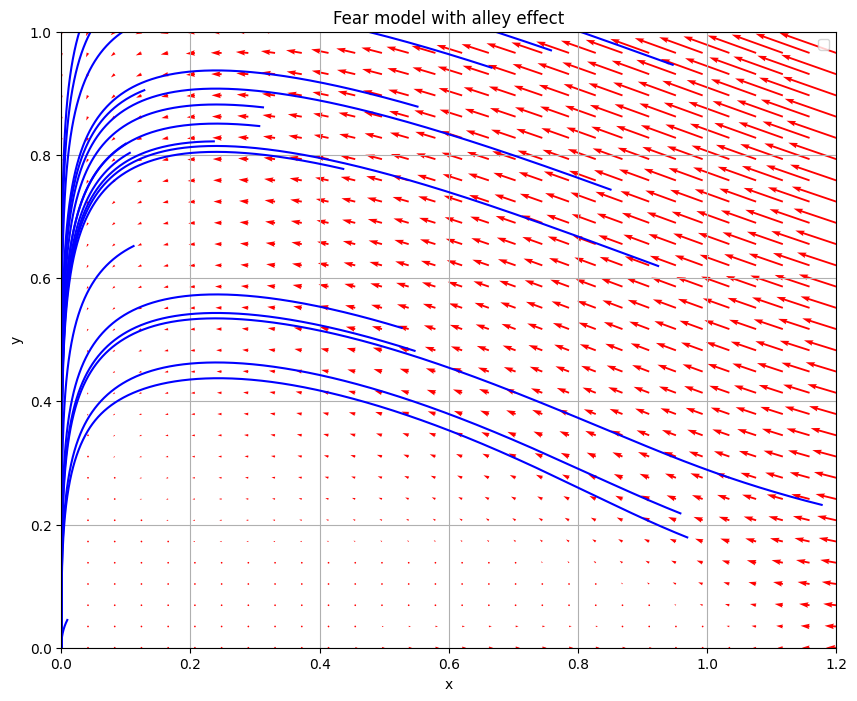

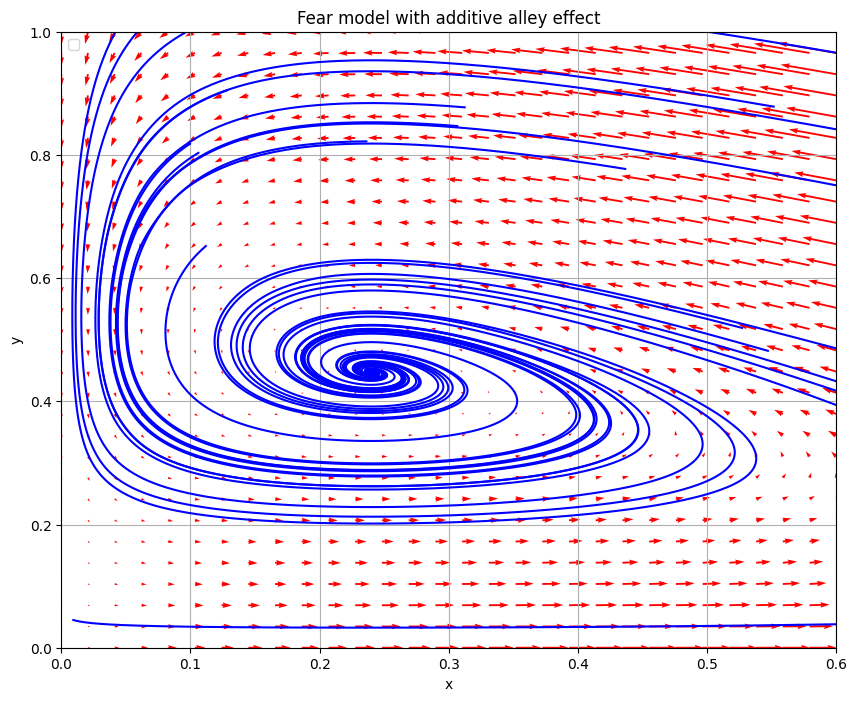

In [204]:
eval = {r:1, m:0.25, s:1.5, a:1, K:1, alpha:0.5, n:0.12, b:20}

limx = (0,1.2)
limy = (0,1)

inicial = [(uniform(limx[0], limx[1]), uniform(limy[0], limy[1])) for _ in range(20)]

diagrama_fases(A, [x, y],
               eval,
               title="Fear model with alley effect",
               limx=limx, limy=limy, n=30,
               inicial=inicial, m=1000)

limx = (0,0.6)
limy = (0,1)

diagrama_fases(B, [x, y],
               eval,
               title="Fear model with additive alley effect",
               limx=limx, limy=limy, n=30,
               inicial=inicial, m=1000)

##### Diagramas de fase para el segundo conjunto de parametros

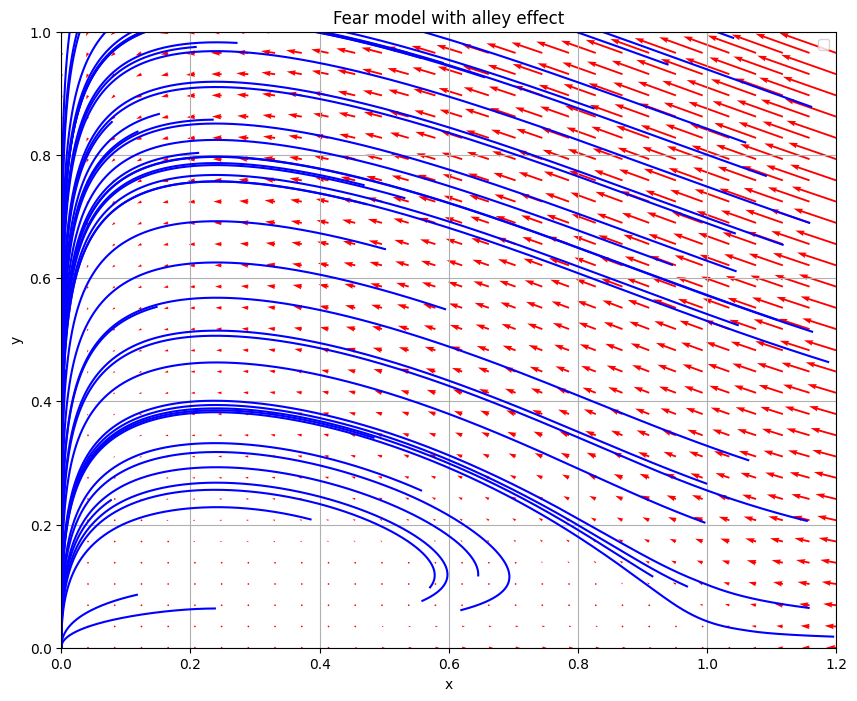

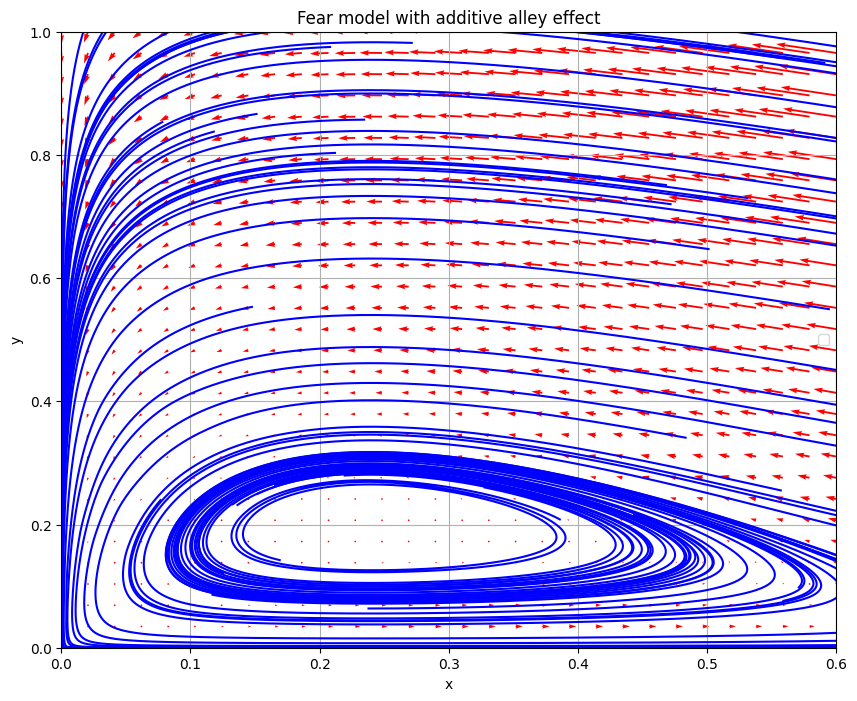

In [206]:
eval = {r:1, m:0.25, s:1.5, a:1, K:1, alpha:0.5, n:0.12, b:0.26}

limx = (0,1.2)
limy = (0,1)

inicial = [(uniform(limx[0], limx[1]), uniform(limy[0], limy[1])) for _ in range(50)]

diagrama_fases(A, [x, y],
               eval,
               title="Fear model with alley effect",
               limx=limx, limy=limy, n=30,
               inicial=inicial, m=1000)

limx = (0,0.6)
limy = (0,1)

diagrama_fases(B, [x, y],
               eval,
               title="Fear model with additive alley effect",
               limx=limx, limy=limy, n=30,
               inicial=inicial, m=1000)

## Referencias

Diz-Pita, É.; Otero-Espinar, M.V. Predator–Prey Models: A Review of Some Recent Advances. Mathematics 2021, 9, 1783. https://doi.org/10.3390/math9151783